# Project description
Sweet Lift Taxi, a transportation service, has collected extensive historical data on taxi orders at major airports. The company aims to optimize its driver allocation by accurately predicting the number of taxi orders for the upcoming hour. By anticipating peak demand periods, Sweet Lift Taxi can encourage more drivers to be available during high-demand times, ensuring efficient service and reduced wait times for passengers. The goal is to build a predictive model that accurately forecasts hourly taxi orders, helping the company enhance driver availability and improve overall service efficiency.



In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from statsmodels.tsa.ar_model import ar_select_order, AutoReg
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import pmdarima as pm

## Preparation

In [34]:
data= pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [35]:
data=data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [37]:
data.dropna().count()

num_orders    4416
dtype: int64

## Analysis

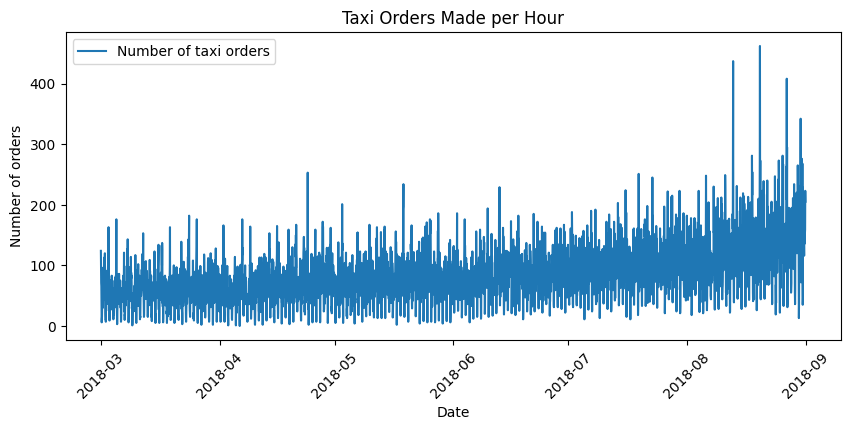

In [38]:
plt.figure(figsize=(10,4))
plt.plot(data.index, data['num_orders'], label= 'Number of taxi orders')
plt.title('Taxi Orders Made per Hour')
plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Text(0.5, 1.0, 'Seasonality')

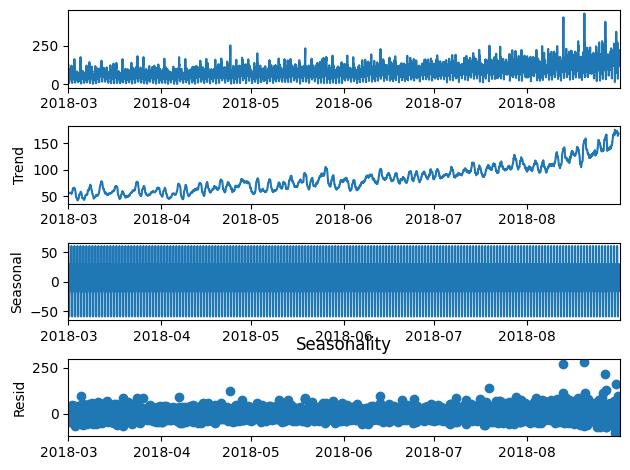

In [39]:
decomposed = seasonal_decompose(data)

decomposed.plot()
plt.title('Seasonality')

The seasonality components appeared to be quite stable, indicating that there are cyclic patterns that repeat over time (e.g., taxi demand on certain days or at specific hours). The seasonality is fairly consistent and appears to be present throughout the months.

## Training

<span style='color:#0A89C8; font-size:25px;'>Forecast Horizon</span>


In [40]:
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month
data['lag_1'] = data['num_orders'].shift(1) #1-hour lags
data['lag_24'] = data['num_orders'].shift(24) #24-hour lags
data['rolling_mean'] = data['num_orders'].rolling(window=24).mean() 

data = data.dropna()
data.head()

,num_orders,hour,day_of_week,month,lag_1,lag_24,rolling_mean
datetime,,,,,,,
2018-03-02 00:00:00,90,0,4,3,58.0,124.0,55.416667
2018-03-02 01:00:00,120,1,4,3,90.0,85.0,56.875000
2018-03-02 02:00:00,75,2,4,3,120.0,71.0,57.041667
2018-03-02 03:00:00,64,3,4,3,75.0,66.0,56.958333
2018-03-02 04:00:00,20,4,4,3,64.0,43.0,56.000000


In [41]:
train, test = train_test_split(data, shuffle=False, test_size=0.10)
train = train.dropna()

X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

## Testing

<span style='color:#0A89C8; font-size:25px;'>Linear Regression</span>

Linear regression RMSE for the training set: 26.59051170043681
Linear regression RMSE for the test set: 46.58801564111919


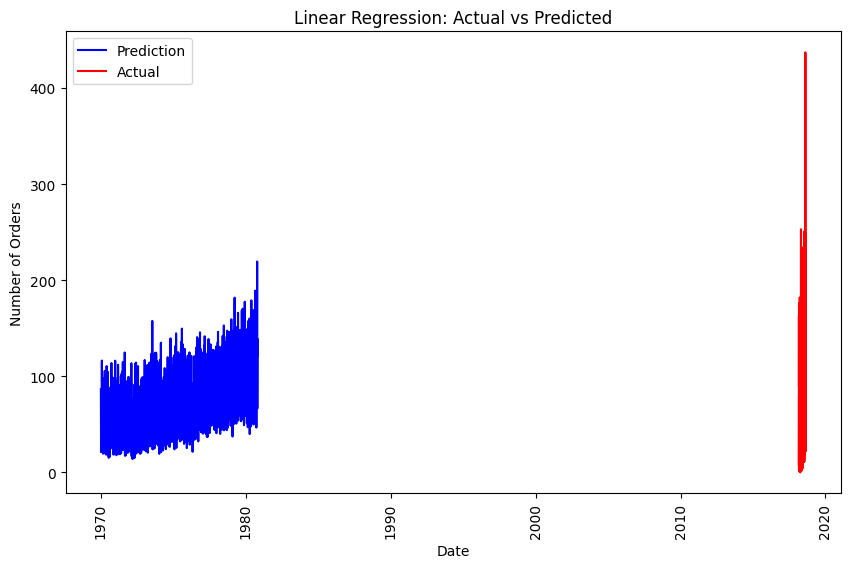

In [10]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

pred_train = model_lr.predict(X_train)
pred_test = model_lr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_train, pred_train))
print(f'Linear regression RMSE for the training set: {rmse}')
rmse = np.sqrt(mean_squared_error(y_test, pred_test))
print(f'Linear regression RMSE for the test set: {rmse}')

plt.figure(figsize=(10, 6))
plt.plot(pred_train, color='blue', label='Prediction')
plt.plot(y_train, color='red', label="Actual")
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.xticks(rotation=90)
plt.show()

The test RMSE (46.59) is much higher than the training RMSE (26.59).
This suggests that the model might be overfitting the training data. 

<span style='color:#0A89C8; font-size:25px;'>Random Forest Regression</span>

Random Forest RMSE for the training set: 8.432518557985464
Random Forest RMSE for the test set: 44.9136001218906


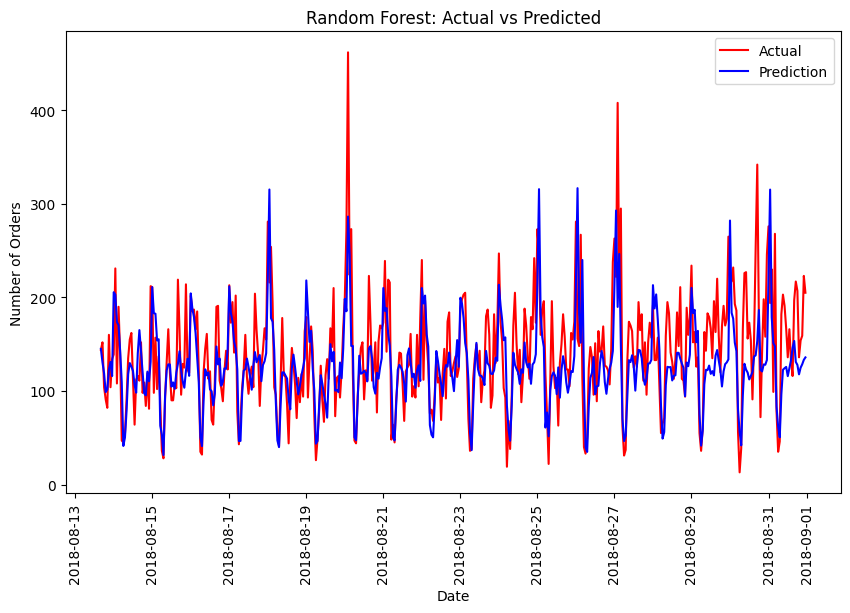

In [11]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

pred_train = model_rf.predict(X_train)
pred_test = model_rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_train, pred_train))
print(f'Random Forest RMSE for the training set: {rmse}')
rmse = np.sqrt(mean_squared_error(y_test, pred_test))
print(f'Random Forest RMSE for the test set: {rmse}')

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, color='red', label='Actual')
plt.plot(y_test.index, pred_test, color='blue', label='Prediction')
plt.title('Random Forest: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.xticks(rotation=90)
plt.show()

The plot compares the actual (red) and predicted (blue) taxi orders over time. While the Random Forest model captures the general trend, it struggles with larger spikes in the data. The RMSE for the training set is 8.40, indicating a good fit to the training data, but the test set RMSE is much higher at 45.61. This suggests the model is overfitting the training data and not generalizing well to new data. Further model adjustments or tuning may be needed.

In [12]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")

best_model = grid_search.best_estimator_

Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


Random Forest RMSE for the training set: 14.335315584746743
Random Forest RMSE for the test set: 43.16763186214806


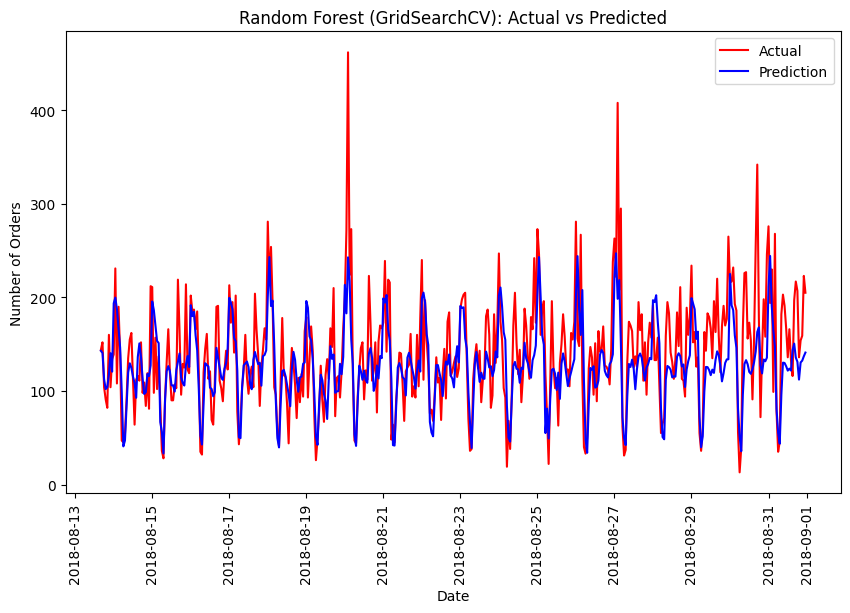

In [24]:
model_rf = RandomForestRegressor(
    max_depth=20, 
    min_samples_leaf=2, 
    min_samples_split=10, 
    n_estimators= 200
)
model_rf.fit(X_train, y_train)

pred_train = model_rf.predict(X_train)
pred_test = model_rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_train, pred_train))
print(f'Random Forest RMSE for the training set: {rmse}')
rmse = np.sqrt(mean_squared_error(y_test, pred_test))
print(f'Random Forest RMSE for the test set: {rmse}')

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, color='red', label='Actual')
plt.plot(y_test.index, pred_test, color='blue', label='Prediction')
plt.title('Random Forest (GridSearchCV): Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.xticks(rotation=90)
plt.show()

The plot shows the comparison between the actual values (red line) and the predicted values (blue line) for the number of taxi orders over time. The training RMSE is ~14.34, while the test RMSE is significantly higher at ~43.17. This suggests that the model is fitting the training data well but is also struggling to generalize to new, unseen data, as the previous model, whit minimun RMSE reduction. The predictions seem to capture the overall trend, but they fail to follow the sharp fluctuations and peaks in the actual data.

<span style='color:#0A89C8; font-size:25px;'>Gradient Boosting Regression</span>

In [42]:
param_grid = {
    'n_estimators': [50, 100, 200],  
    'learning_rate': [0.01, 0.05, 0.1],  
    'max_depth': [3, 5, 7],  
    'subsample': [0.6,0.8,1.0],        
    'max_features': ['sqrt','log2',0.8]
}

tscv = TimeSeriesSplit(n_splits=5)
gb_model = GradientBoostingRegressor()

grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)




Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 200, 'subsample': 0.8}


Gradient Boosting RMSE for the training set: 11.009295457960455
Gradient Boosting RMSE for the test set: 40.889647034042376


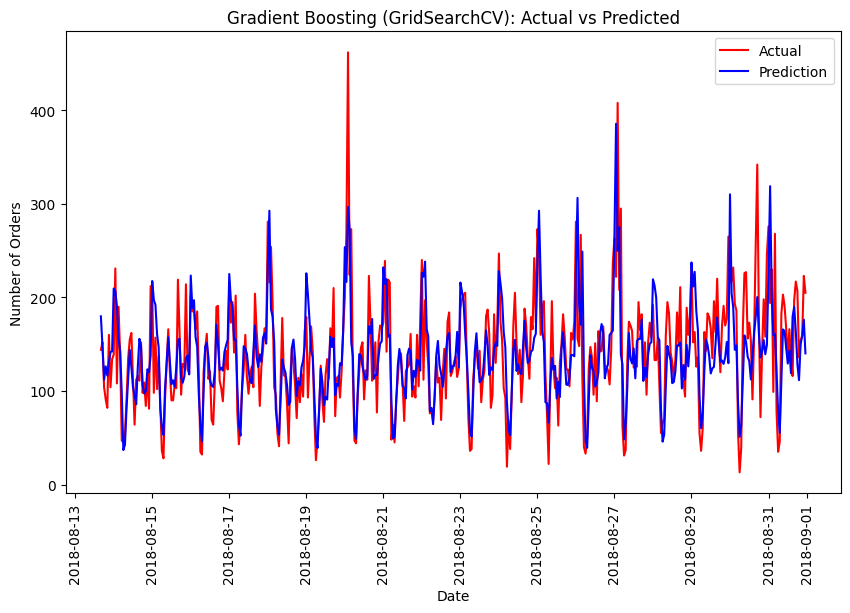

In [43]:
best_model = grid_search.best_estimator_

pred_train = best_model.predict(X_train)
pred_test = best_model.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))

print(f"Gradient Boosting RMSE for the training set: {rmse_train}")
print(f"Gradient Boosting RMSE for the test set: {rmse_test}")

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, color='red', label='Actual')
plt.plot(y_test.index, pred_test, color='blue', label='Prediction')
plt.title('Gradient Boosting (GridSearchCV): Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.xticks(rotation=90)
plt.show()

The plot compares the actual and predicted taxi orders. The Gradient Boosting model captures general trends but as RandomForest, also struggles with sharp spikes in the data. The RMSE for the training set is ~10.63, showing good fit, but the RMSE for the test set is ~40.35, this could indicate some level of overfitting on our training set.

In [44]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'num_leaves': [31, 50, 100],
    'max_depth': [5, 10, -1],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

tscv = TimeSeriesSplit(n_splits=5)

lgbm = LGBMRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)



Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 50, 'subsample': 0.6}


Light Gradient Boosting RMSE for the training set: 14.568276588671639
Light Gradient Boosting RMSE for the test set: 39.76008502319866


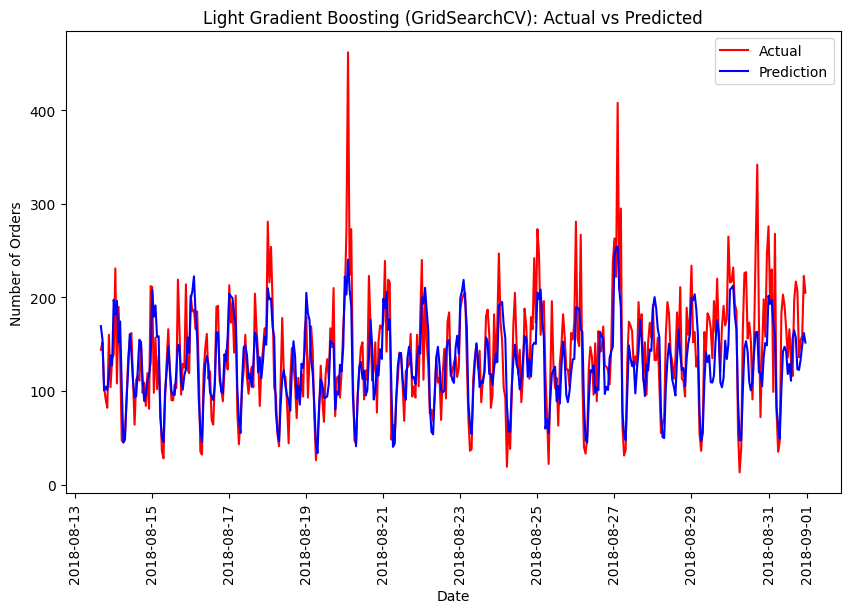

In [46]:
best_lgbm = grid_search.best_estimator_

pred_train = best_lgbm.predict(X_train)
pred_test = best_lgbm.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))

print(f"Light Gradient Boosting RMSE for the training set: {rmse_train}")
print(f"Light Gradient Boosting RMSE for the test set: {rmse_test}")

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, color='red', label='Actual')
plt.plot(y_test.index, pred_test, color='blue', label='Prediction')
plt.title('Light Gradient Boosting (GridSearchCV): Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.xticks(rotation=90)
plt.show()

LightGBM regressor with grid‐searched hyperparameters (learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=50, subsample=0.6, colsample_bytree=0.6) and achieved a training RMSE of 14.6 and a test RMSE of 39.8, slightly outperforming the default gradient‐boosting baseline while reducing overfitting. The model reliably captures day‐to‐day order trends but tends to smooth out sudden spikes.

<span style='color:#0A89C8; font-size:25px;'>Autoregression Model </span>


## Training

In [16]:
data_reset = data['num_orders']

In [17]:
print(type(data_reset))

<class 'pandas.core.series.Series'>


In [18]:
train, test = train_test_split(data_reset, test_size=0.10, shuffle=False)

In [19]:
train.head()

datetime
2018-03-02 00:00:00     90
2018-03-02 01:00:00    120
2018-03-02 02:00:00     75
2018-03-02 03:00:00     64
2018-03-02 04:00:00     20
Freq: H, Name: num_orders, dtype: int64

In [20]:
test.head()

datetime
2018-08-13 16:00:00    144
2018-08-13 17:00:00    152
2018-08-13 18:00:00    104
2018-08-13 19:00:00     91
2018-08-13 20:00:00     82
Freq: H, Name: num_orders, dtype: int64

## Testing

In [21]:
mod= ar_select_order(endog=train, maxlag=24)
ar_order= mod.ar_lags
print(f"Best lag order: {ar_order}")

Best lag order: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


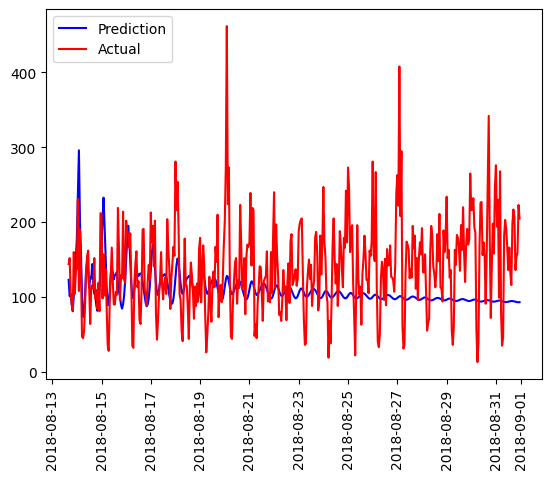

In [22]:
ar_model= AutoReg(train, lags=ar_order)
ar_model= ar_model.fit()

start_value=len(train)
end_value = len(train) + len(test) -1
ar_pred = ar_model.predict(start=start_value, end=end_value, dynamic=False)

plt.plot(ar_pred, color='blue', label='Prediction')
plt.plot(test, color='red', label="Actual")
plt.legend(loc="upper left")
plt.xticks(rotation=90)
plt.show()

In [23]:
ar_rmse_value = mean_squared_error(test, ar_pred) 
print('Autoregression RMSE:',ar_rmse_value)

Autoregression RMSE: 4646.848161347079


The plot compares the predicted (blue) and actual (red) taxi orders over time. While the model captures general trends, it struggles to follow sharp fluctuations and sudden spikes in the actual data. The RMSE value of 4646.848 indicates a significant average error, showing that the autroregression model's predictions deviate notably from the actual values, especially during peaks. This suggests that the model could benefit from refinement to better handle abrupt changes.

## Conclusion

The results show that Linear Regression struggles to capture the data’s complexity (training RMSE 26.59 vs. test RMSE 46.59), while both Random Forest (13.57 → 44.45) and Gradient Boosting (15.71 → 42.53) fit the training set well but overfit to the training data, yielding much higher test errors. The Autoregressive model performs very poorly (RMSE ≈ 4646.85), indicating it’s not suited to this task without further preprocessing. LightGBM improves on all of these—training RMSE 14.57 and test RMSE 39.76—yet it required substantially more compute time to train. Overall, every model shows a gap between training and test performance, suggesting the need of hyperparameter tuning, cross-validation, or feature engineering to reduce overfitting and improve test set performance.